In [212]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pyodbc

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [214]:
server = 'tcp:illidan.database.windows.net' 
database = 'Traffic_Pollution' 
username = 'silax' 
password = 'Polska0!'  
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [215]:
createQuery = '''
DROP TABLE IF EXISTS dbo.RowProcessing
SELECT identity(int,1,1) AS CID, [_datetime], [id], [_value], ROW_NUMBER() Over (Partition By [_datetime] Order By [_datetime]) As RowID
into dbo.RowProcessing
FROM [dbo].[Readings]
WHERE id IN (2766, 2768, 2770, 2774, 17896)
	AND [_datetime] > \'2020-09-30 13:00:00.000\'
	ORDER BY [_datetime], [id]'''

cursor.execute(createQuery)
cursor.commit()

In [216]:
query = '''
SELECT fp.[_datetime] 
      ,fp.[_value] AS NO2
	  ,o3.[_value] AS O3	  
	  ,pm10.[_value] AS PM10
	  ,so2.[_value] AS SO2
	  ,c6h6.[_value] AS C6H6
	  , ff.[Speed_Uncapped]/ff.[Free_Flow] AS [Difference]
      , ff.[Jam_Factor]
FROM dbo.RowProcessing as fp
LEFT JOIN dbo.RowProcessing AS c6h6 ON fp.[_datetime] = c6h6.[_datetime] AND c6h6.RowID = 5
LEFT JOIN dbo.RowProcessing AS o3 ON fp.[_datetime] = o3.[_datetime] AND o3.RowID = 2
LEFT JOIN dbo.RowProcessing AS pm10 ON fp.[_datetime] = pm10.[_datetime] AND pm10.RowID = 3
LEFT JOIN dbo.RowProcessing AS so2 ON fp.[_datetime] = so2.[_datetime] AND so2.RowID = 4
   LEFT JOIN dbo.FactFlow AS ff ON fp.[_datetime] = ff.[Timestamp] AND ff.[Station] = 401 
  AND ff.[StreetKey] = 93
  WHERE fp.RowID = 1
''' 

df = pd.read_sql(query, cnxn, parse_dates=['_datetime'])

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(df.head(26))

             _datetime   NO2    O3   PM10   SO2  C6H6  Difference  Jam_Factor
0  2021-02-17 11:00:00  78.0   6.0   76.0  12.0   0.0    0.902697     1.44169
1  2021-02-17 12:00:00  56.0  17.0   53.0  12.0   0.0    0.940462     0.88230
2  2021-02-17 13:00:00  49.0  25.0   78.0  14.0   1.0    0.950867     0.72723
3  2021-02-17 14:00:00  45.0  23.0   65.0  13.0   1.0    1.058285     0.00000
4  2021-02-17 15:00:00  38.0  24.0   22.0   8.0   0.0    0.790270     3.10735
5  2021-02-17 16:00:00  36.0  24.0   15.0   5.0   0.0    0.718979     4.12566
6  2021-02-17 17:00:00  37.0  26.0   16.0   8.0   0.0    0.658382     4.81810
7  2021-02-14 09:00:00  16.0  56.0   27.0  12.0   NaN    1.235742     0.00000
8  2021-02-14 10:00:00  15.0  58.0   24.0  11.0   0.0    1.237187     0.00000
9  2021-02-14 11:00:00  15.0  59.0   25.0  11.0   0.0    1.205973     0.00000
10 2021-02-14 12:00:00  15.0  60.0   26.0  12.0   0.0    1.086898     0.00000
11 2021-02-14 13:00:00  16.0  61.0   28.0  11.0   0.0    1.20520

In [381]:
df['_datetime'] =pd.to_datetime(df['_datetime'])
df.sort_values(by=['_datetime'], inplace=True)


KeyError: '_datetime'

In [218]:
df.head()

_datetime   NO2   O3  PM10  SO2  C6H6  Difference  Jam_Factor
269 2020-09-30 14:00:00  34.0  7.0   0.0  2.0   1.0    0.741979     3.82204
270 2020-09-30 15:00:00  36.0  4.0   0.0  4.0   1.0    0.590682     5.59176
271 2020-09-30 16:00:00  40.0  5.0   0.0  4.0   1.0    0.596158     5.52981
272 2020-09-30 17:00:00  41.0  4.0   0.0  3.0   1.0    0.827858     2.55006
273 2020-09-30 18:00:00  42.0  4.0   0.0  3.0   1.0    1.057829     0.00000

In [219]:
date_time = df.pop('_datetime')

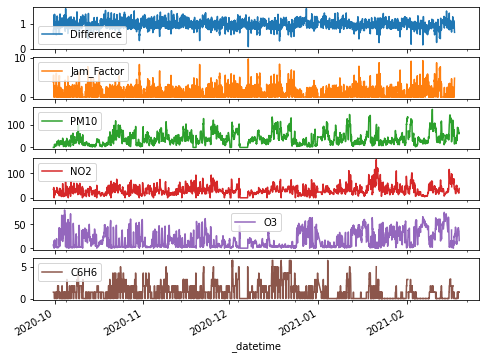

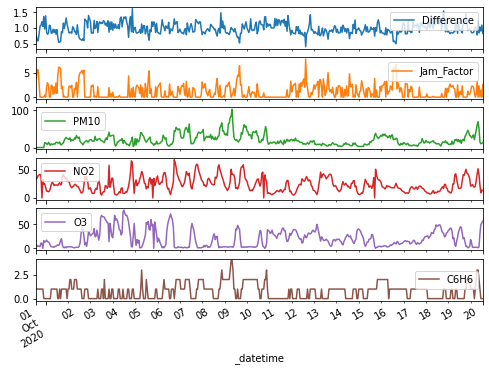

In [220]:
plot_cols = ['Difference', 'Jam_Factor', 'PM10', 'NO2', 'O3', 'C6H6']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][0:480]
plot_features.index = date_time[0:480]
_ = plot_features.plot(subplots=True)

In [221]:
df.head()

NO2   O3  PM10  SO2  C6H6  Difference  Jam_Factor
269  34.0  7.0   0.0  2.0   1.0    0.741979     3.82204
270  36.0  4.0   0.0  4.0   1.0    0.590682     5.59176
271  40.0  5.0   0.0  4.0   1.0    0.596158     5.52981
272  41.0  4.0   0.0  3.0   1.0    0.827858     2.55006
273  42.0  4.0   0.0  3.0   1.0    1.057829     0.00000

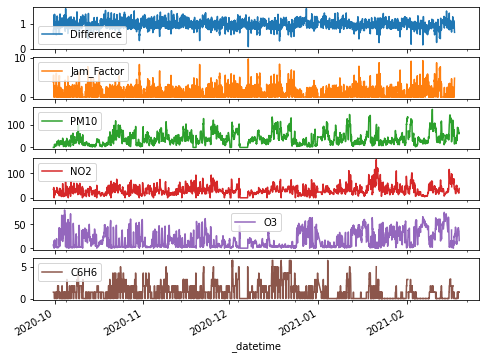

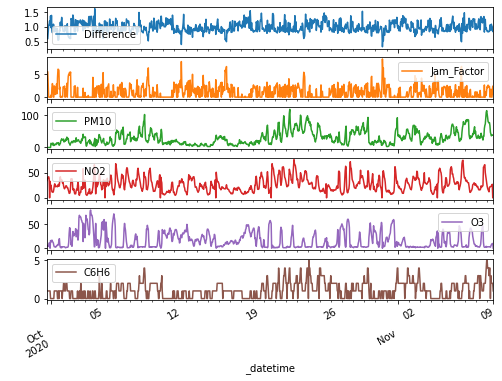

In [222]:
plot_cols = ['Difference', 'Jam_Factor', 'PM10', 'NO2', 'O3', 'C6H6']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][0:960]
plot_features.index = date_time[0:960]
_ = plot_features.plot(subplots=True)

In [223]:
dfnn = df.fillna(0)

In [225]:
dfnn.describe().transpose()

count       mean        std  min        25%        50%  \
NO2         3474.0  30.921992  18.625732  0.0  18.000000  27.000000   
O3          3474.0  18.458261  17.854698  0.0   3.000000  11.000000   
PM10        3474.0  39.443293  28.995692  0.0  19.000000  32.000000   
SO2         3474.0   6.192861   4.443094  0.0   3.000000   5.000000   
C6H6        3474.0   1.050950   1.205370  0.0   0.000000   1.000000   
Difference  3474.0   0.953749   0.213652  0.0   0.856671   0.954803   
Jam_Factor  3474.0   1.147930   1.464068  0.0   0.000000   0.530610   

                  75%         max  
NO2         39.000000  156.000000  
O3          31.000000   80.000000  
PM10        53.000000  169.000000  
SO2          8.000000   50.000000  
C6H6         2.000000    6.000000  
Difference   1.077217    1.621484  
Jam_Factor   2.043862    9.742690

In [226]:
dfnn.isnull().sum()

NO2           0
O3            0
PM10          0
SO2           0
C6H6          0
Difference    0
Jam_Factor    0
dtype: int64

In [227]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [228]:
date_time

269    2020-09-30 14:00:00
270    2020-09-30 15:00:00
271    2020-09-30 16:00:00
272    2020-09-30 17:00:00
273    2020-09-30 18:00:00
               ...        
3444   2021-02-19 05:00:00
3437   2021-02-19 06:00:00
3409   2021-02-19 07:00:00
3410   2021-02-19 08:00:00
3420   2021-02-19 09:00:00
Name: _datetime, Length: 3474, dtype: datetime64[ns]

In [229]:
day = 24*60*60
week = 7*day
year = (365.2425)*day

dfnn['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dfnn['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dfnn['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
dfnn['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
dfnn['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dfnn['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

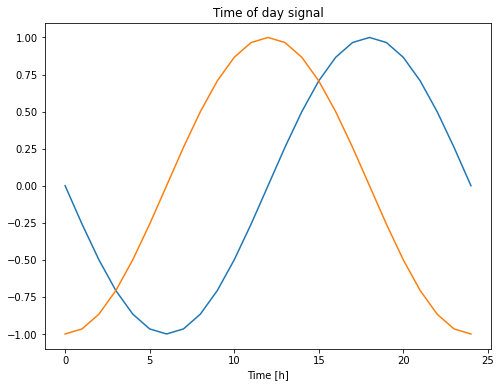

In [230]:
plt.plot(np.array(dfnn['Day sin'])[0:25])
plt.plot(np.array(dfnn['Day cos'])[0:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of week signal')

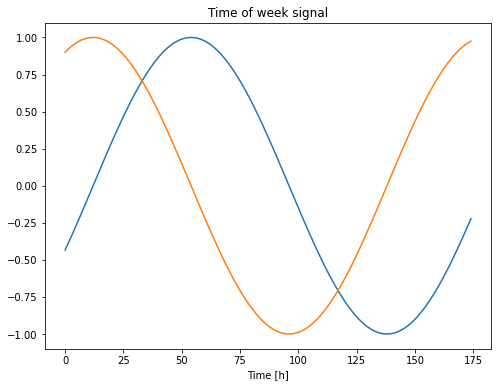

In [231]:
plt.plot(np.array(dfnn['Week sin'])[0:175])
plt.plot(np.array(dfnn['Week cos'])[0:175])
plt.xlabel('Time [h]')
plt.title('Time of week signal')

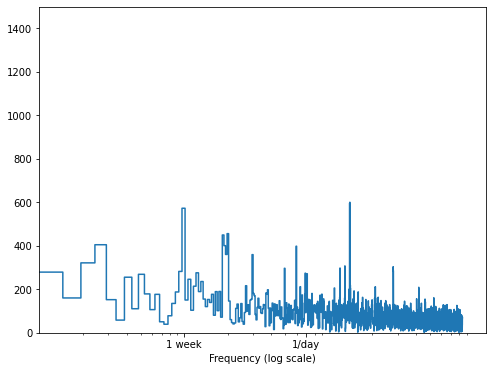

In [232]:
fft = tf.signal.rfft(dfnn['Jam_Factor'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(dfnn['Jam_Factor'])
#hours_per_year = 24*365.2524
hours_per_week = 24*7 
weeks_per_dataset = n_samples_h/(hours_per_week)
#years_per_dataset = n_samples_h/(hours_per_year)

#f_per_year = f_per_dataset/years_per_dataset
f_per_week = f_per_dataset/weeks_per_dataset
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1500)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7], labels=['1 week' ,'1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [387]:
column_indices = {name: i for i, name in enumerate(dfnn.columns)}

n = len(dfnn)
train_df = dfnn[0:int(n*0.7)]
val_df = dfnn[int(n*0.7):int(n*0.9)]
test_df = dfnn[int(n*0.9):]

num_features = dfnn.shape[1]

NameError: name 'MinMaxScaler' is not defined

In [372]:
train_df

NO2        O3      PM10       SO2      C6H6  Difference  \
269   0.399026 -0.466969 -1.403440 -0.959565 -0.211494   -1.166455   
270   0.531175 -0.662603 -1.403440 -0.211664 -0.211494   -1.934333   
271   0.795471 -0.597392 -1.403440 -0.211664 -0.211494   -1.906544   
272   0.861545 -0.662603 -1.403440 -0.585614 -0.211494   -0.730593   
273   0.927619 -0.662603 -1.403440 -0.585614 -0.211494    0.436582   
...        ...       ...       ...       ...       ...         ...   
2900 -0.327788  0.706837 -0.191029  1.658087 -1.018625    1.072577   
2901  0.002582 -0.140911 -0.073699  2.032037 -1.018625    0.223269   
2902  0.795471 -0.793026  0.200071  1.658087 -1.018625   -0.399654   
2977  2.381248 -0.727815  0.630281  0.910187 -0.211494    1.129784   
2978  2.447323 -0.727815  0.708501  0.536236 -0.211494   -0.020228   

      Jam_Factor   Day sin   Day cos  Week sin  Week cos  Year sin  Year cos  
269     1.956075  0.002478 -1.411503 -0.633741  1.264913 -1.182399 -2.150818  
270     3.226079 -0.363203 -1.363289 -0.585321  1.286803 -1.182417 -2.148537  
271     3.181622 -0.703963 -1.221932 -0.536105  1.306894 -1.182434 -2.146257  
272     1.043264 -0.996580 -0.997066 -0.486161  1.325156 -1.182449 -2.143976  
273    -0.786735 -1.221113 -0.704014 -0.435559  1.341566 -1.182463 -2.141695  
...          ...       ...       ...       ...       ...       ...       ...  
2900   -0.786735 -0.996580 -0.997066 -0.175183 -1.394829  2.052250  1.012134  
2901   -0.786735 -1.221113 -0.704014 -0.227999 -1.387977  2.054192  1.011733  
2902    0.350299 -1.362261 -0.362748 -0.280517 -1.379183  2.056133  1.011330  
2977   -0.786735 -1.410404  0.003475 -0.332665 -1.368460  2.058074  1.010926  
2978   -0.445064 -1.362261  0.369699 -0.384370 -1.355823  2.060015  1.010520  

[2431 rows x 13 columns]

In [320]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std




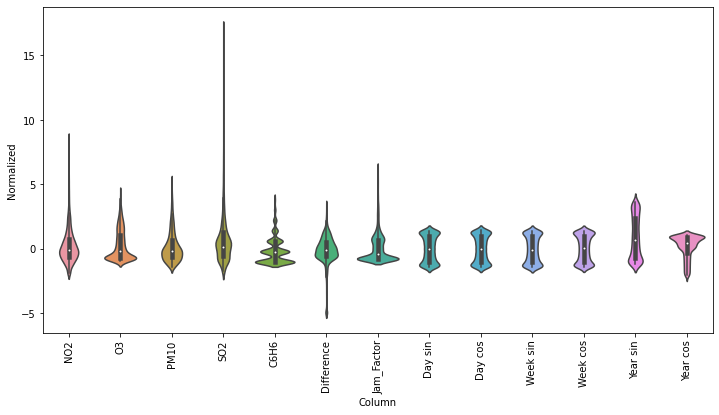

In [235]:
df_std = (dfnn - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfnn.keys(), rotation=90)

In [236]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [237]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Jam_Factor'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Jam_Factor']

In [238]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Jam_Factor'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Jam_Factor']

In [239]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [347]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 13)
Inputs shape: (3, 6, 13)
labels shape: (3, 1, 1)


In [241]:
w2.example = example_inputs, example_labels

TypeError: tuple indices must be integers or slices, not tuple

In [242]:
def plot(self, model=None, plot_col='Jam_Factor', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [366]:
def plot2(self, model=None, plot_col='Jam_Factor', max_subplots=3):
  inputs, labels = self.example
  #indicesdenorm = self.input_indices*train_std+train_mean 
  inputs = (inputs*train_std)+train_mean 
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    #print(labels[n, :, label_col_index]*train_std+train_mean)
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot2 = plot2

tf.Tensor(
[-0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524
 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524
 -0.78673524], shape=(13,), dtype=float32)
tf.Tensor(
[-0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524
 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524 -0.78673524
 -0.78673524], shape=(13,), dtype=float32)
tf.Tensor(
[-0.10177904 -0.10177904 -0.10177904 -0.10177904 -0.10177904 -0.10177904
 -0.10177904 -0.10177904 -0.10177904 -0.10177904 -0.10177904 -0.10177904
 -0.10177904], shape=(13,), dtype=float32)


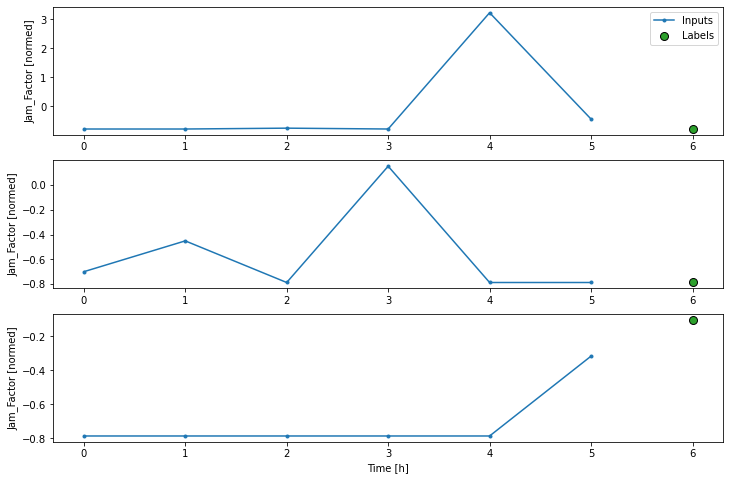

In [367]:
w2.plot2()

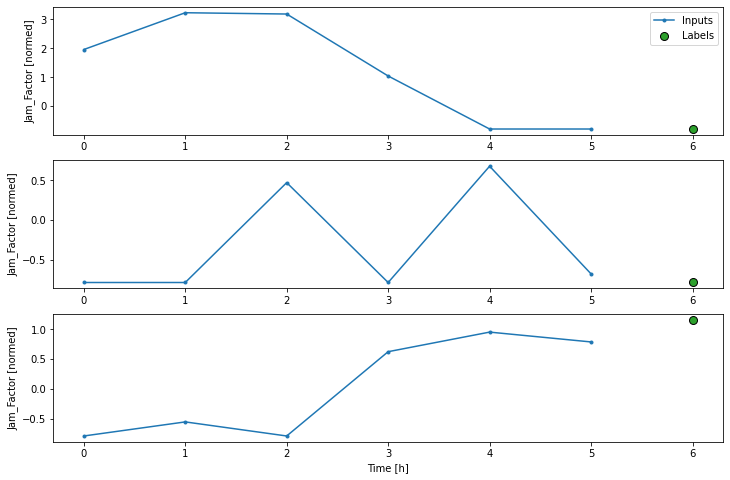

In [243]:
w2.plot()

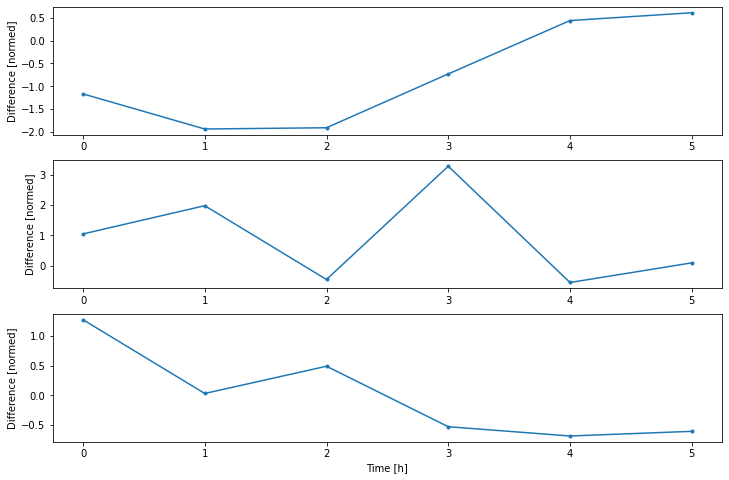

In [244]:
w2.plot(plot_col='Difference')

In [245]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [246]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [248]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 13)
Labels shape (batch, time, features): (32, 1, 1)


In [249]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Jam_Factor'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Jam_Factor']

In [342]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs}')
  print(f'Labels shape (batch, time, features): {example_labels}')

Inputs shape (batch, time, features): [[[ 2.66878337e-01 -7.27814496e-01  5.52061141e-01  1.62286103e-01
    1.40276682e+00  8.78952265e-01 -7.86735237e-01  1.00153637e+00
    1.00401652e+00  4.54769999e-01 -1.32487988e+00  1.04032421e+00
    1.00222027e+00]]

 [[-1.05460298e+00 -2.71334350e-01 -3.47469509e-01 -5.85614383e-01
    1.40276682e+00  2.53691101e+00 -7.86735237e-01  1.00153637e+00
   -9.97065663e-01  1.43792048e-01 -1.39482939e+00 -9.45229590e-01
   -8.27718556e-01]]

 [[-1.12067699e+00  7.06837416e-01 -6.60349727e-01 -9.59564626e-01
   -2.11494073e-01  1.57707691e-01 -7.86735237e-01 -7.03962803e-01
    1.22888291e+00  6.96528792e-01 -1.21558344e+00 -1.06759608e+00
   -1.21036351e+00]]

 [[-3.93862307e-01  5.11203051e-01 -2.69249469e-01  2.03203726e+00
   -1.01862454e+00  6.81905150e-01 -7.86735237e-01  2.47809524e-03
   -1.41150331e+00  1.09798336e+00 -8.75113249e-01  1.99973536e+00
    1.02235663e+00]]

 [[-1.18675113e+00 -1.40911460e-01  4.52073943e-03 -5.85614383e-01
   

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'map'

In [251]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [252]:
baseline = Baseline(label_index=column_indices['Jam_Factor'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

22/22 [==============================] - 0s 4ms/step - loss: 1.1591 - mean_absolute_error: 0.6778


In [330]:
baseline.predict(dfnn)

AttributeError: 'MapDataset' object has no attribute 'head'

In [253]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Jam_Factor'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Jam_Factor']

In [254]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


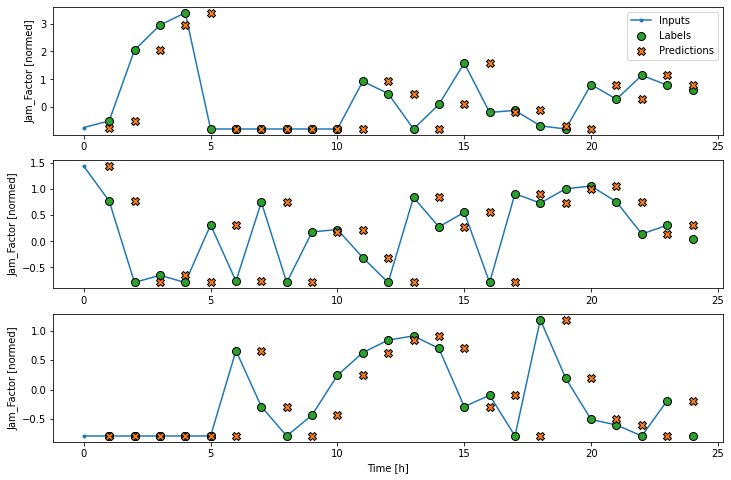

In [255]:
wide_window.plot(baseline)

In [256]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [257]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


In [258]:
#package training procedure inside function
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [259]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
76/76 [==============================] - 1s 7ms/step - loss: 2.1708 - mean_absolute_error: 1.1691 - val_loss: 4.5174 - val_mean_absolute_error: 1.7377
Epoch 2/20
76/76 [==============================] - 0s 4ms/step - loss: 1.7938 - mean_absolute_error: 1.0642 - val_loss: 3.8611 - val_mean_absolute_error: 1.5845
Epoch 3/20
76/76 [==============================] - 0s 3ms/step - loss: 1.5710 - mean_absolute_error: 0.9972 - val_loss: 3.3471 - val_mean_absolute_error: 1.4531
Epoch 4/20
76/76 [==============================] - 0s 4ms/step - loss: 1.3955 - mean_absolute_error: 0.9393 - val_loss: 2.9225 - val_mean_absolute_error: 1.3371
Epoch 5/20
76/76 [==============================] - 0s 3ms/step - loss: 1.2419 - mean_absolute_error: 0.8870 - val_loss: 2.6190 - val_mean_absolute_error: 1.2489
Epoch 6/20
76/76 [==============================] - 0s 5ms/step - loss: 1.1733 - mean_absolute_error: 0.8623 - val_loss: 2.3576 - val_mean_absolute_error: 1.1693
Epoch 7/20
76/76 [==========

In [371]:
history


In [260]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


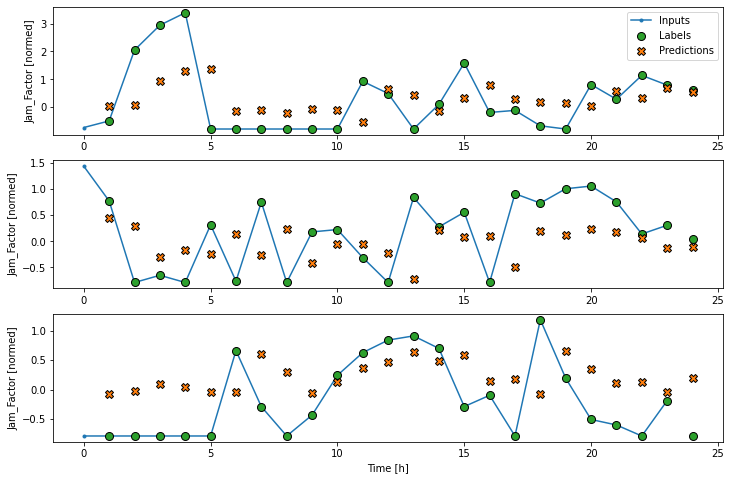

In [261]:
wide_window.plot(linear)

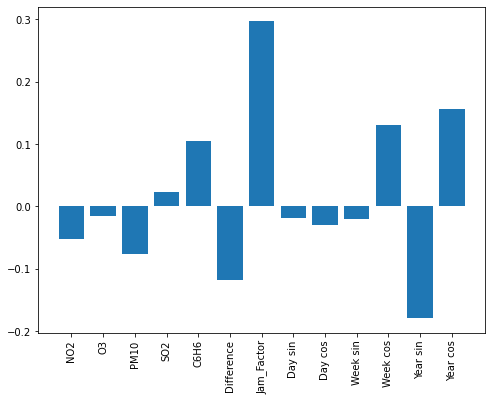

In [262]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [263]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
76/76 [==============================] - 1s 5ms/step - loss: 0.8749 - mean_absolute_error: 0.7356 - val_loss: 1.1880 - val_mean_absolute_error: 0.7481
Epoch 2/20
76/76 [==============================] - 0s 3ms/step - loss: 0.7777 - mean_absolute_error: 0.6749 - val_loss: 1.0646 - val_mean_absolute_error: 0.7311
Epoch 3/20
76/76 [==============================] - 0s 3ms/step - loss: 0.7107 - mean_absolute_error: 0.6603 - val_loss: 1.1450 - val_mean_absolute_error: 0.7447
Epoch 4/20
22/22 [==============================] - 0s 1ms/step - loss: 1.1161 - mean_absolute_error: 0.7370


In [264]:
CONV_WIDTH = 12
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Jam_Factor'])

conv_window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12]
Label column name(s): ['Jam_Factor']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

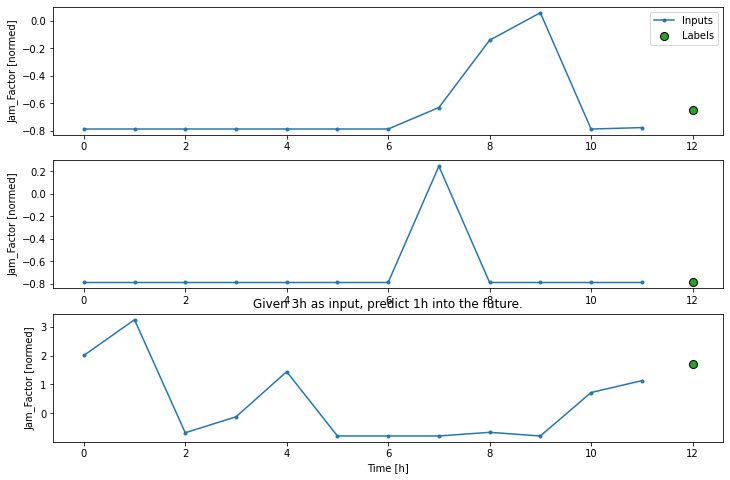

In [265]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [266]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [267]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 12, 13)
Output shape: (32, 1, 1)


In [268]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

22/22 [==============================] - 0s 902us/step - loss: 1.5918 - mean_absolute_error: 0.9077


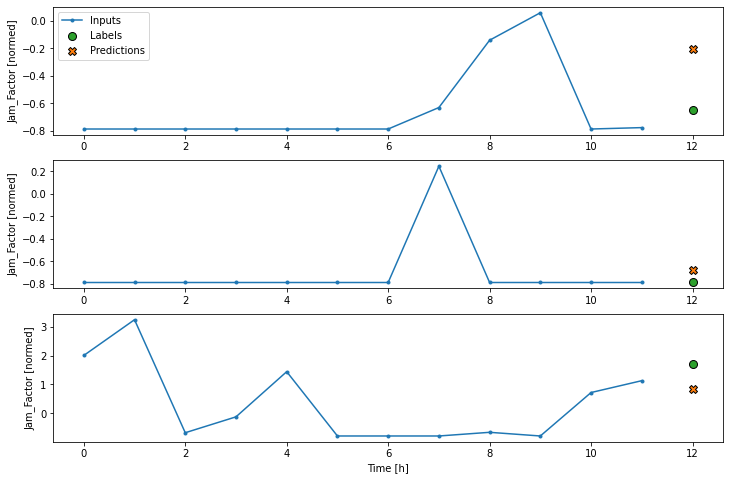

In [269]:
conv_window.plot(multi_step_dense)

In [270]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 13)

ValueError:Input 0 of layer dense_11 is incompatible with the layer: expected axis -1 of input shape to have value 156 but received input with shape (32, 312)


In [271]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [272]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 12, 13)
Output shape: (32, 1, 1)


In [273]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

22/22 [==============================] - 0s 1ms/step - loss: 1.2503 - mean_absolute_error: 0.7752


In [274]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 13, 1)


In [275]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Jam_Factor'])

wide_conv_window

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Label indices: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]
Label column name(s): ['Jam_Factor']

In [276]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 35, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [379]:
wide_conv_window.example[1]

<tf.Tensor: shape=(32, 24, 1), dtype=float32, numpy=
array([[[-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.76780415],
        [-0.16709054],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524]],

       [[ 0.06802655],
        [-0.0315446 ],
        [-0.78673524],
        [ 0.70716923],
        [-0.78673524],
        [-0.78673524],
        [ 0.99578565],
        [ 0.01098215],
        [-0.733401  ],
        [ 0.774404  ],
        [-0.46423954],
        [-0.08746231],
        [ 0.21158841],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
        [-0.78673524],
  

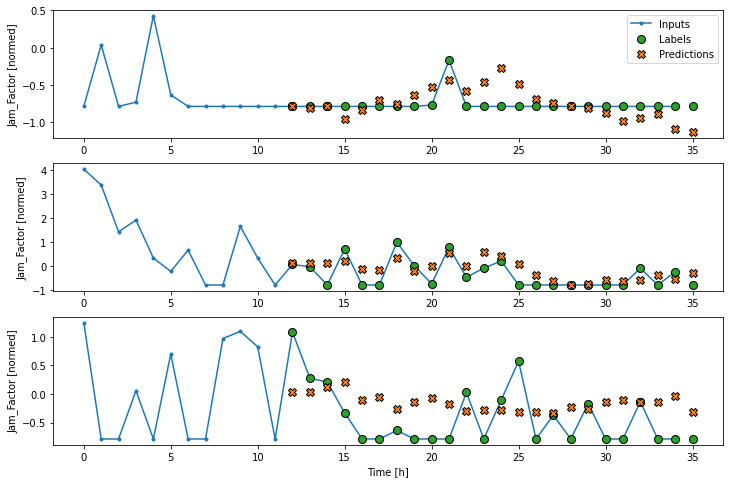

In [277]:
wide_conv_window.plot(conv_model)

In [278]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [279]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


In [280]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

21/21 [==============================] - 0s 3ms/step - loss: 1.1400 - mean_absolute_error: 0.7611


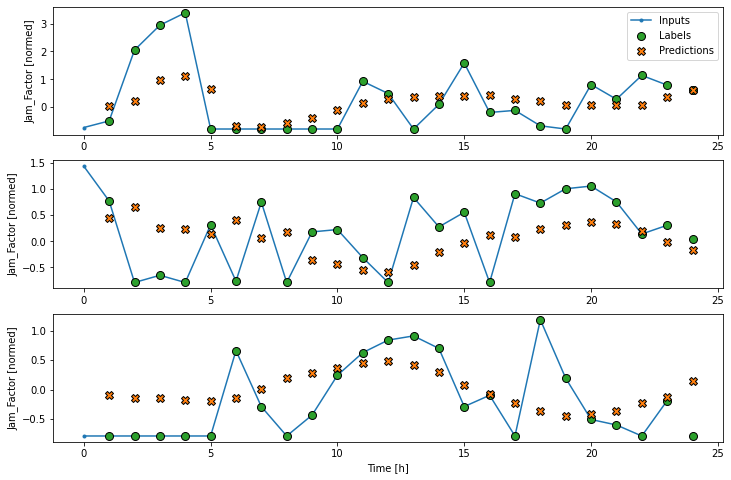

In [281]:
wide_window.plot(lstm_model)

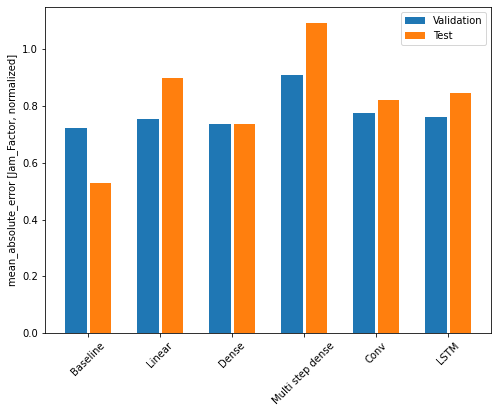

In [283]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Jam_Factor, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [284]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.5268
Linear      : 0.8972
Dense       : 0.7352
Multi step dense: 1.0923
Conv        : 0.8199
LSTM        : 0.8438


In [285]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 13)
Labels shape (batch, time, features): (32, 24, 13)


In [286]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [287]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

21/21 [==============================] - 0s 3ms/step - loss: 0.3085 - mean_absolute_error: 0.2753


In [385]:
prediction = baseline.predict(wide_window.test)

In [386]:
prediction.shape[0]

324

In [288]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [289]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

22/22 [==============================] - 0s 2ms/step - loss: 0.3253 - mean_absolute_error: 0.3595


In [290]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

21/21 [==============================] - 0s 4ms/step - loss: 0.4428 - mean_absolute_error: 0.4203

Wall time: 20.4 s


In [291]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [292]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

21/21 [==============================] - 0s 4ms/step - loss: 0.2619 - mean_absolute_error: 0.2658

Wall time: 11.7 s


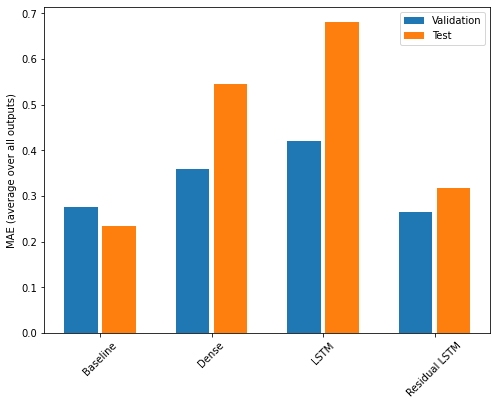

In [293]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [294]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.2336
Dense          : 0.5450
LSTM           : 0.6802
Residual LSTM  : 0.3163


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

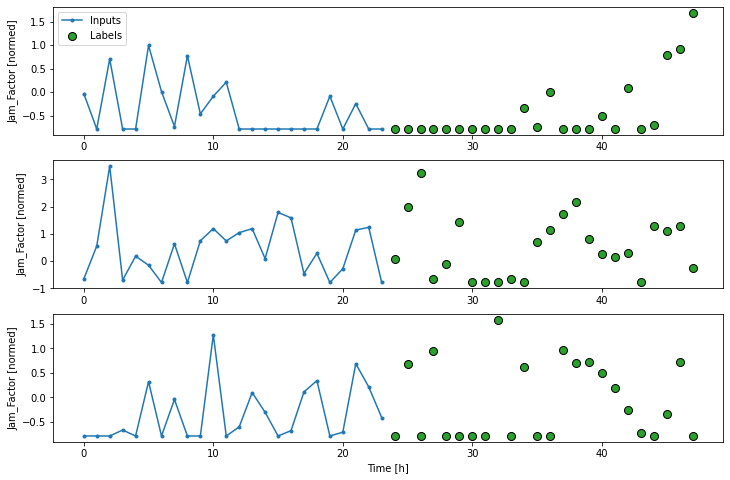

In [295]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

21/21 [==============================] - 0s 2ms/step - loss: 1.3268 - mean_absolute_error: 0.7277


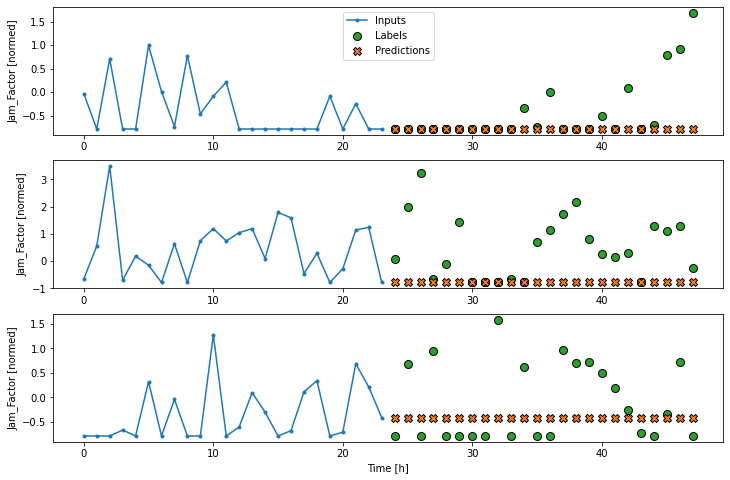

In [296]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

21/21 [==============================] - 0s 1ms/step - loss: 1.3359 - mean_absolute_error: 0.6845


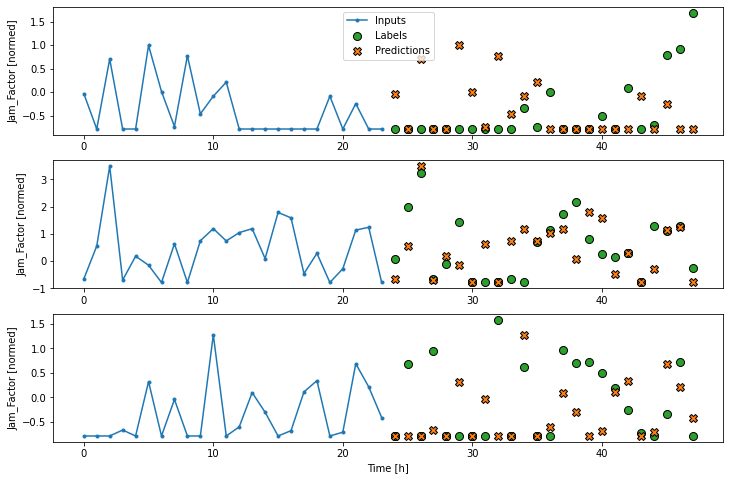

In [297]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

21/21 [==============================] - 0s 2ms/step - loss: 0.7832 - mean_absolute_error: 0.5710


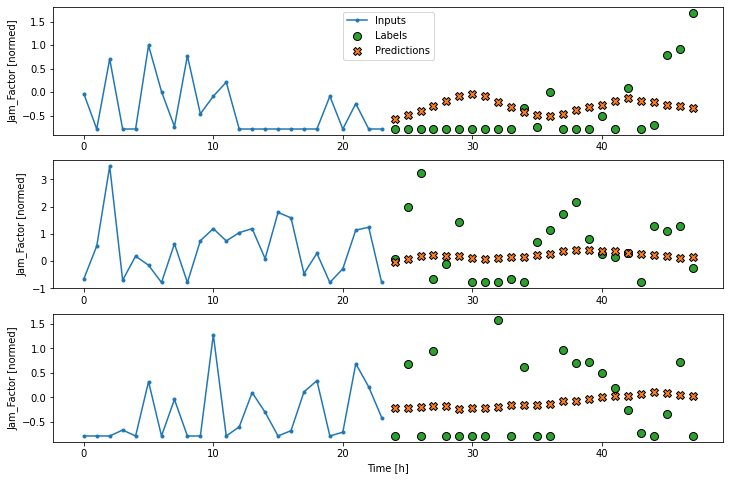

In [298]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

21/21 [==============================] - 0s 1ms/step - loss: 0.7346 - mean_absolute_error: 0.4934


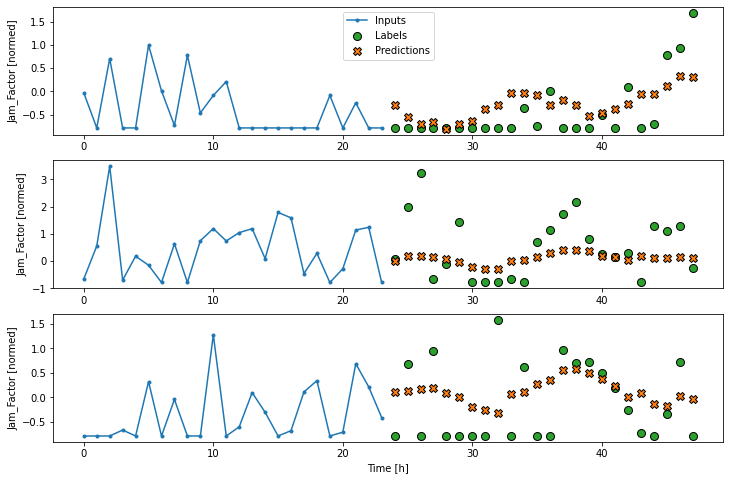

In [299]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

21/21 [==============================] - 0s 2ms/step - loss: 0.7492 - mean_absolute_error: 0.5135


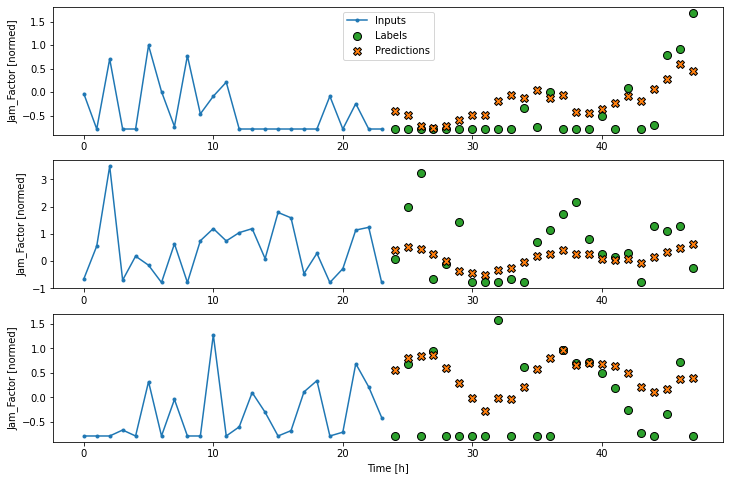

In [300]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

21/21 [==============================] - 0s 3ms/step - loss: 0.9221 - mean_absolute_error: 0.6706


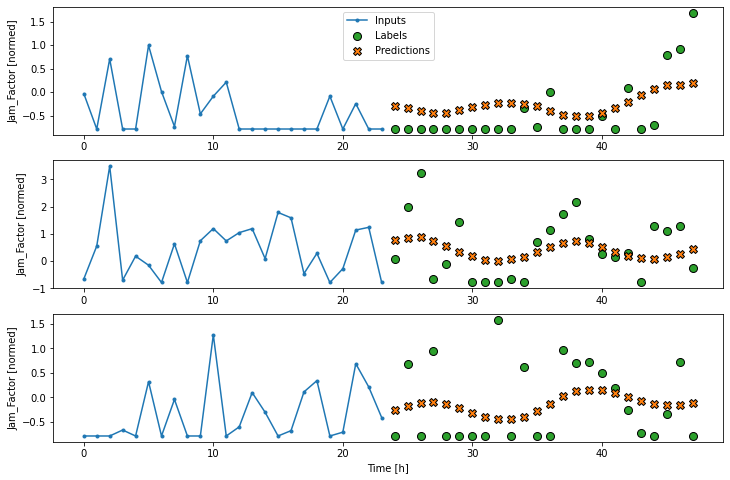

In [301]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [302]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [303]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [304]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [305]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [306]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 13)


21/21 [==============================] - 0s 6ms/step - loss: 1.0553 - mean_absolute_error: 0.6904


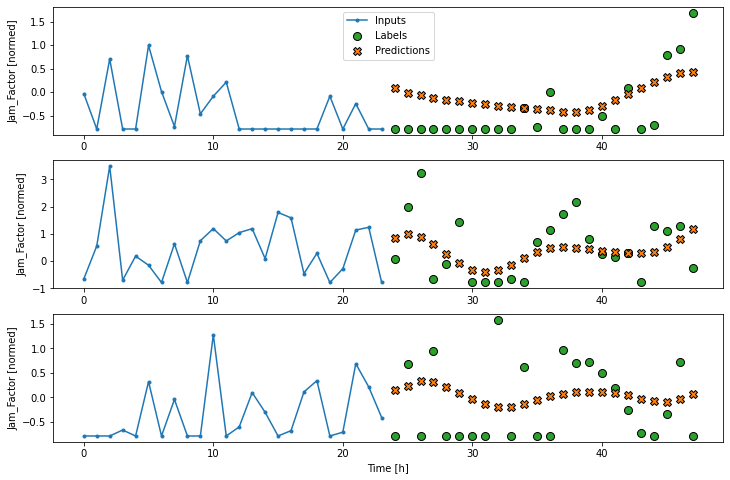

In [307]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

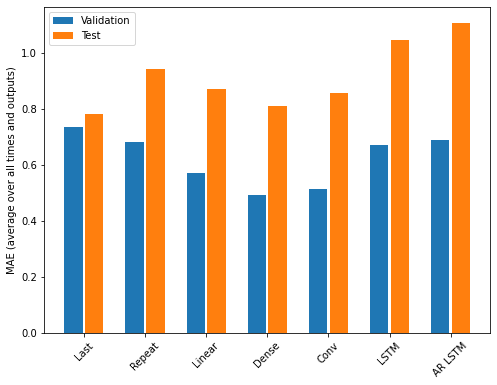

In [308]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [309]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.7844
Repeat  : 0.9444
Linear  : 0.8716
Dense   : 0.8115
Conv    : 0.8597
LSTM    : 1.0489
AR LSTM : 1.1098


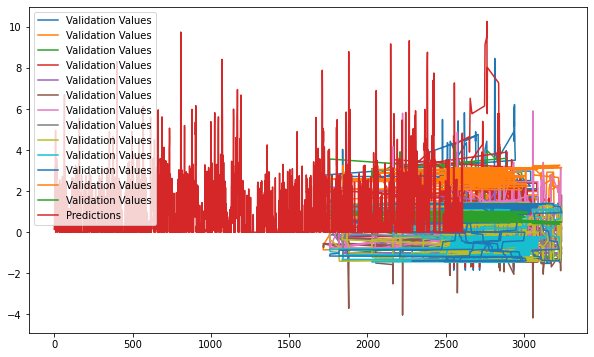

In [377]:
predict_mean = dfnn.mean()
predict_std = dfnn.std()
predict_df = (dfnn - train_mean) / train_std

forecast = []

for time in range(len(predict_df) - 24):
  forecast.append(baseline.predict(predict_df[time:time + 24]['Jam_Factor']))

forecast = forecast[850-24:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plt.plot(val_df, label='Validation Values')
plt.plot(results, labels='Predictions')
plt.legend()